In [1]:
from spin_system import SpinSystem
from spin_system import interactions
from spin_system.plots import plot_spin_evolution

import numpy as np

import matplotlib.pyplot as plt
import time
import numpy as np
import matplotlib.pyplot as plt
import psutil
import os
import gc
import pandas as pd


2025-10-01 22:16:36.962073: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-01 22:16:37.006891: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# --------------------------
# 3. Helper: measure performance
# --------------------------
def run_with_timing(params):
    """Run a single simulation with timing and memory usage."""
    gc.collect()
    process = psutil.Process(os.getpid())
    
    start_time = time.perf_counter()
    start_mem = process.memory_info().rss / 1e6  # MB
    
    # Run simulation
    interaction_matrix = interactions.periodic_nn(
        params["lattice_dim"], params["lattice_length"]
    )
    ising_spin_system = SpinSystem(
        lattice_dim=params["lattice_dim"],
        lattice_length=params["lattice_length"],
        lattice_replicas=params["lattice_replicas"],
        interaction_matrix=interaction_matrix,
        model="ising",
        initial_magnetization=params["initial_magnetization"]
    )
    
    results = ising_spin_system.metropolis_sweep(
        beta=params["beta"],
        num_disturb=params["num_disturb"],
        sweep_length=params["sweep_length"],
        track_spins=params["track_spins"],
        track_energy=params["track_energy"],
        track_magnetization=params["track_magnetization"]
    )
    
    end_time = time.perf_counter()
    end_mem = process.memory_info().rss / 1e6
    
    return {
        "runtime": end_time - start_time,
        "mem_used": end_mem - start_mem,
        "results": results
    }

# --------------------------
# 4. Base parameters
# --------------------------
base_params = dict(
    lattice_dim=2,
    lattice_length=32,
    lattice_replicas=32,
    sweep_length=1000,
    beta=1.0,
    num_disturb=1,
    initial_magnetization=0.5,
    track_spins=True,
    track_energy=True,
    track_magnetization=True
)

In [3]:
# --------------------------
# 5. Experiments
# --------------------------

def plot_experiment(values, label, param_name):
    plt.figure(figsize=(8,5))
    plt.plot(values, label["times"], marker="o")
    plt.xlabel(param_name)
    plt.ylabel("Runtime (s)")
    plt.title(f"Runtime vs {param_name}")
    plt.grid(True)
    plt.show()


I0000 00:00:1759367798.863752   62196 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1479 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


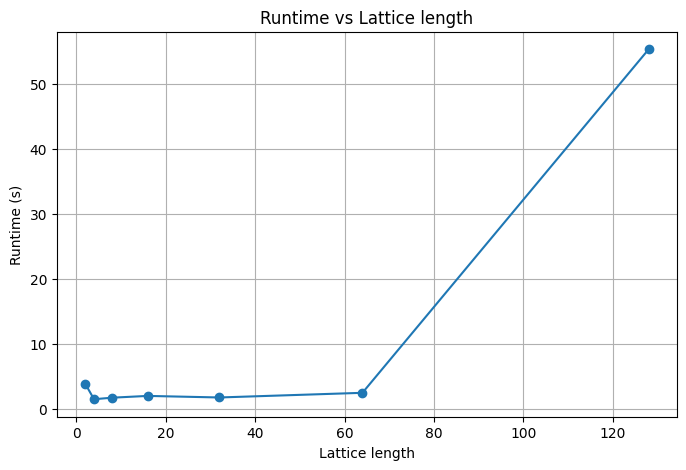

In [4]:
# ---- A. Lattice length
lattice_lengths = [2, 4, 8, 16, 32, 64, 128]
times = []
for L in lattice_lengths:
    p = base_params.copy()
    p["lattice_length"] = L
    perf = run_with_timing(p)
    times.append(perf["runtime"])
plot_experiment(lattice_lengths, {"times": times}, "Lattice length")

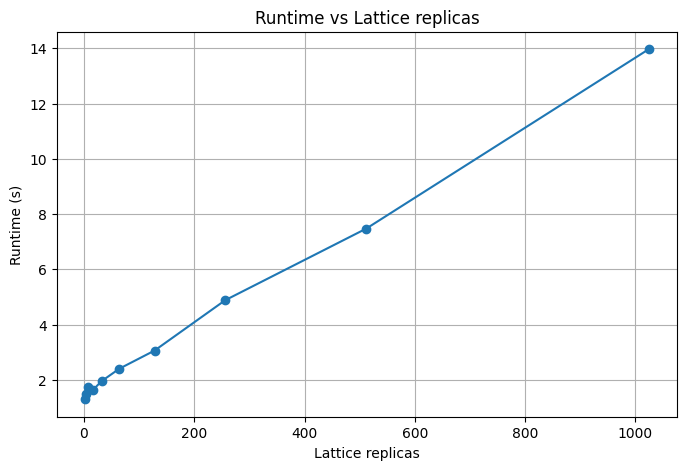

In [5]:
# ---- A.1 Lattice replicas
lattice_replicas = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
times = []
for R in lattice_replicas:
    p = base_params.copy()
    p["lattice_replicas"] = R
    perf = run_with_timing(p)
    times.append(perf["runtime"])
plot_experiment(lattice_replicas, {"times": times}, "Lattice replicas")

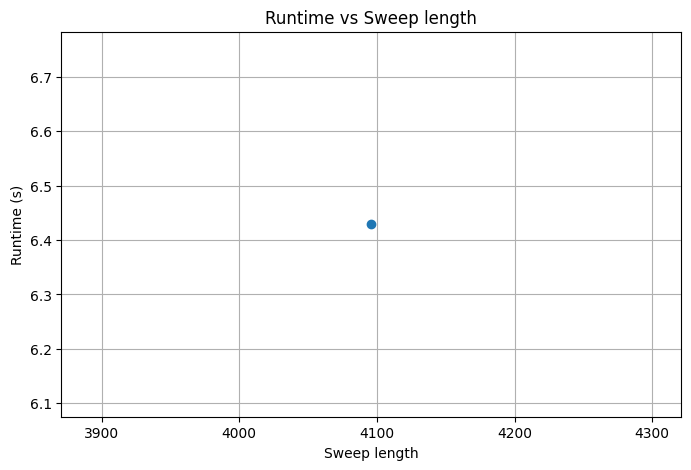

In [13]:
# ---- B. Sweep length
sweep_lengths = [4096]
times = []
for S in sweep_lengths:
    p = base_params.copy()
    p["sweep_length"] = S
    perf = run_with_timing(p)
    times.append(perf["runtime"])
plot_experiment(sweep_lengths, {"times": times}, "Sweep length")

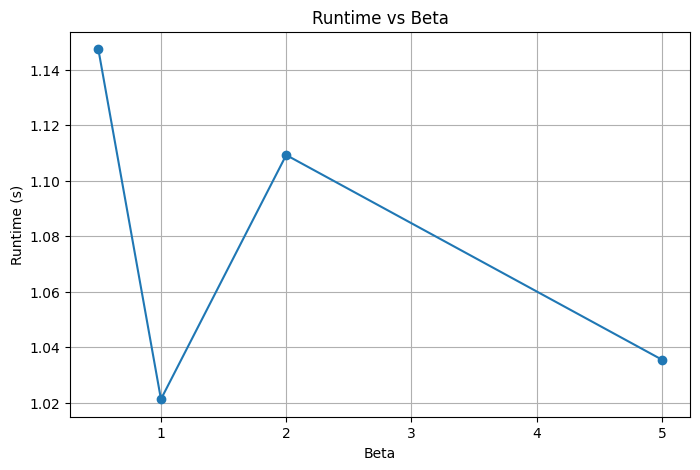

In [ ]:
# ---- C. Beta
betas = [0.01, 0.2, 0.44, 0.6, 0.8, 1]
times = []
for b in betas:
    p = base_params.copy()
    p["beta"] = b
    perf = run_with_timing(p)
    times.append(perf["runtime"])
plot_experiment(betas, {"times": times}, "Beta")

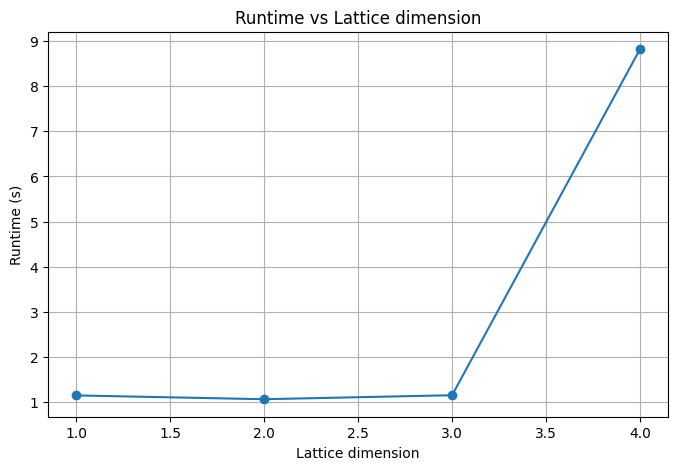

In [ ]:
# ---- D. Lattice dimension
dims = [1, 2, 3, 4]
times = []
for d in dims:
    p = base_params.copy()
    p["lattice_length"] = 10
    p["lattice_dim"] = d
    perf = run_with_timing(p)
    times.append(perf["runtime"])
plot_experiment(dims, {"times": times}, "Lattice dimension")

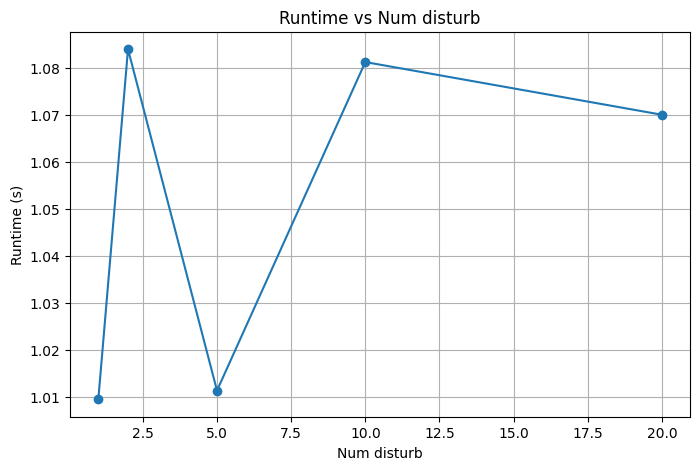

In [ ]:
# ---- E. Num disturb
num_disturbs = [1, 2, 5, 10, 20]
times = []
for nd in num_disturbs:
    p = base_params.copy()
    p["num_disturb"] = nd
    perf = run_with_timing(p)
    times.append(perf["runtime"])
plot_experiment(num_disturbs, {"times": times}, "Num disturb")

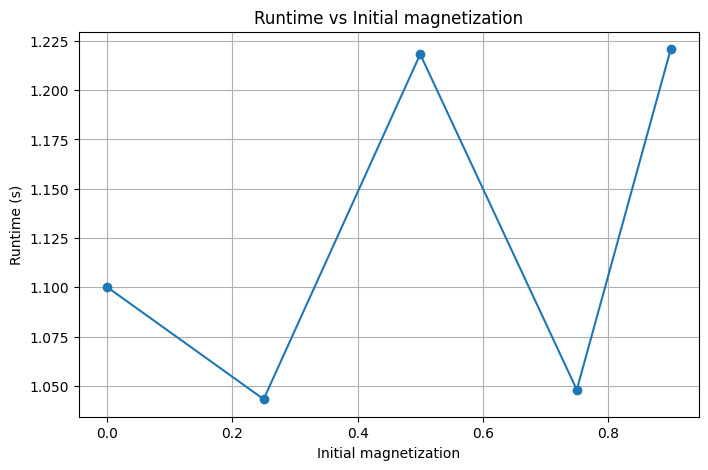

In [ ]:
# ---- F. Initial magnetization
init_mags = [0.0, 0.25, 0.5, 0.75, 0.9]
times = []
for m in init_mags:
    p = base_params.copy()
    p["initial_magnetization"] = m
    perf = run_with_timing(p)
    times.append(perf["runtime"])
plot_experiment(init_mags, {"times": times}, "Initial magnetization")

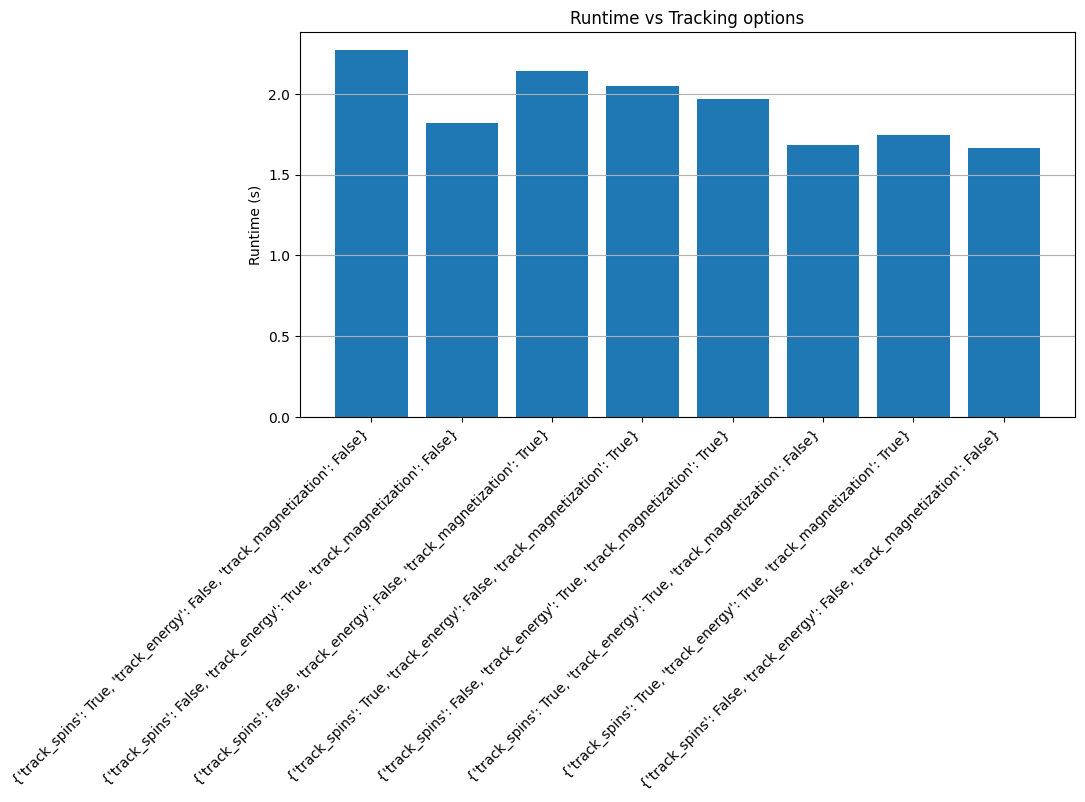

In [8]:
# ---- G. Tracking flags
tracking_settings = [
    {"track_spins": True,  "track_energy": False, "track_magnetization": False},
    {"track_spins": False, "track_energy": True,  "track_magnetization": False},
    {"track_spins": False, "track_energy": False,  "track_magnetization": True},
    {"track_spins": True,  "track_energy": False, "track_magnetization": True},
    {"track_spins": False, "track_energy": True,  "track_magnetization": True},
    {"track_spins": True, "track_energy": True,  "track_magnetization": False},
    {"track_spins": True,  "track_energy": True,  "track_magnetization": True},
    {"track_spins": False, "track_energy": False, "track_magnetization": False},
]

times = []
labels = []
for tset in tracking_settings:
    p = base_params.copy()
    p.update(tset)
    perf = run_with_timing(p)
    times.append(perf["runtime"])
    labels.append(str(tset))

plt.figure(figsize=(10,5))
plt.bar(range(len(times)), times)
plt.xticks(range(len(times)), labels, rotation=45, ha="right")
plt.ylabel("Runtime (s)")
plt.title("Runtime vs Tracking options")
plt.grid(True, axis="y")
plt.show()